# 3 Pre-Processing & Training

In our last step, we did some joining of our data based on latitude and longitude and explored our features. In this next step we will prepare for modeling by tuning our features, and maybe even adding a feature or two. We will have some challenges with finding the right mix and tuning of features when our initial correlation review didn't show much to work with. Maybe more challenging will be how to deal with our fairly imbalanced data.

## 3.0 Imports

In [541]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn import __version__ as sklearn_version

from imblearn.over_sampling import SMOTENC #using SMOTENC because it accepts a mix of numeric and categorical values

#imports for saving model
import os
import pickle

## 3.1 Load Data

In [542]:
trees_df = pd.read_csv('../data/data_outputs/seattle_trees_explored.csv')

trees_df.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between,temp_avg_normal,temp_min_normal,temp_max_normal,temp_range_normal,prcp_mm_normal,tree_id
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,...,237,1071.925479,0.0,0.947927,53.2,45.7,60.8,15.0,960.628,1
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,...,237,1071.925479,0.0,3.367105,53.2,45.7,60.8,15.0,960.628,2
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,...,237,1071.925479,0.0,1.145690,53.2,45.7,60.8,15.0,960.628,3


## 3.2 Prep DF for Train-Test split

We'll take another look at the columns, as we can likely drop the additional reference info from our climate 'prcp' data source. And then we'll split our dependent and independent variables.

### 3.2.0 Drop Unecessary Columns

We'll drop the reference cols from climate data like I mentioned above, but also the 'condition' column because it is duplicative of our target feature. Our tree_id because it has no more use. And our date cols, because we have the calculated age feature that will be our variable related to dates/ages.

In [543]:
#View our columns
trees_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158004 entries, 0 to 158003
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   planted_date               155133 non-null  object 
 1   most_recent_observation    157999 non-null  object 
 2   common_name                157332 non-null  object 
 3   long_trees                 158004 non-null  float64
 4   lat_trees                  158004 non-null  float64
 5   diameter_breast_height_CM  158004 non-null  float64
 6   condition                  158004 non-null  object 
 7   native                     158004 non-null  object 
 8   age_at_obs                 155128 non-null  float64
 9   condition_index            158004 non-null  float64
 10  nearest_station            158004 non-null  object 
 11  station_id                 158004 non-null  object 
 12  station_name               158004 non-null  object 
 13  lat_prcp                   15

In [544]:
#drop our columns that are reference from climate dataset and the original condition column (which we used to create our target index feature)
trees_df = trees_df.drop(columns=['nearest_station', 'station_id',
       'station_name', 'lat_prcp', 'long_prcp', 'condition', 'planted_date','most_recent_observation','tree_id','long_trees','lat_trees','temp_min_normal','temp_max_normal','temp_range_normal']) #also drop some of the climate normals fields since they don't add anything

In [545]:
trees_df.columns

Index(['common_name', 'diameter_breast_height_CM', 'native', 'age_at_obs',
       'condition_index', 'adj_reports', 'norm_prcp_mm_total',
       'norm_snow_mm_total', 'distance_between', 'temp_avg_normal',
       'prcp_mm_normal'],
      dtype='object')

### 3.2.1 Sample Dataset to Make Size More Manageable
One model may not be too crazy, but running a gridsearch CV on hundreds of thousands of rows may be a bit much for me. I'll start with a sample of 10,000.

In [546]:
trees_sample = trees_df.sample(n=10000, replace=False, random_state=42)

### 3.2.2 Split Dependent and Independent Variables

In [547]:
# split data into X and y
X = trees_sample.drop(columns=['condition_index'])
y = trees_sample['condition_index']

## 3.3 Train-Test Split
We'll use an 80:20 split here

In [548]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8000, 10) (8000,) (2000, 10) (2000,)


## 3.4 Impute Missing Values

We will use the median for our age at observation and mode for common name.

### 3.4.0 Establish Simple Imputers

In [549]:
X_train.isna().sum()

common_name                   43
diameter_breast_height_CM      0
native                         0
age_at_obs                   155
adj_reports                    0
norm_prcp_mm_total             0
norm_snow_mm_total             0
distance_between               0
temp_avg_normal                0
prcp_mm_normal                 0
dtype: int64

In [550]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')

### 3.4.1 Impute Values

In [551]:
#fit and transform
X_train['age_at_obs'] = num_imputer.fit_transform(X_train[['age_at_obs']])
X_train['common_name'] = cat_imputer.fit_transform(X_train[['common_name']])

In [552]:
#validate no missing values
X_train.isna().sum()

common_name                  0
diameter_breast_height_CM    0
native                       0
age_at_obs                   0
adj_reports                  0
norm_prcp_mm_total           0
norm_snow_mm_total           0
distance_between             0
temp_avg_normal              0
prcp_mm_normal               0
dtype: int64

## 3.5 Simple Feature Engineering

Before running a first test model, I'll do some basic feature engineering. After testing on a single model we'll move into doing further tuning.

### 3.5.1 Categorical Encoding

We'll need to encode our categorical features. And for our tree names, we'll likely need to group together some of the less frequent options so we don't overwhelm our model with a crazy number of columns.

In [553]:
cat_columns = trees_df.select_dtypes(include='object').columns

cat_columns

Index(['common_name', 'native'], dtype='object')

In [554]:
#view value_counts of common_name field
X_train['common_name'].value_counts()

Red maple                  287
Purpleleaf plum variety    237
Norway maple               216
Apple/crabapple            215
(smooth) japanese maple    202
                          ... 
Snow gum                     1
Cascade snow cherry          1
Javelin pear                 1
Oceanspray                   1
Almond tree                  1
Name: common_name, Length: 485, dtype: int64

In [555]:
#how many of the 485 categories have less than 10 records?

vc = pd.DataFrame(X_train['common_name'].value_counts())

vc.reset_index(inplace=True)

vc[vc['common_name'] < 3].value_counts()

index                       common_name
(arnold) tulip tree         1              1
Pacific yew                 1              1
Patmore green ash           1              1
Paw paw                     1              1
Plane/sycamore              2              1
                                          ..
Empire ash                  2              1
English elm                 1              1
Eucalyptus/gum              2              1
Eugene`s (carolina) poplar  2              1
Zelkova                     2              1
Length: 182, dtype: int64

In [556]:
#view value_counts of common_name field
trees_df['native'].value_counts()

introduced             116127
no_info                 32616
naturally_occurring      9261
Name: native, dtype: int64

#### 3.5.1.0 Convert common_name Field to Group Names with < 100 Occurences

This will limit the number of columns we have. We won't do thes ame for the native field. We'll do it by defining a function that can be utilized later as well.

In [557]:
def group_categories(df, col, n_limit):
    """ Store categories in df[col] with counts less than the specified n and overwrite the corresponding values in the df with 'Other' """
    groups = df[col]
    group_counts = groups.value_counts()
    mask = groups.isin(group_counts[group_counts<n_limit].index)
    df.loc[mask, col] = 'Other'

In [558]:
#use our group categories feature on our X_train set
group_categories(X_train, 'common_name', 3)

X_train['common_name'].value_counts()

Red maple                  287
Other                      257
Purpleleaf plum variety    237
Norway maple               216
Apple/crabapple            215
                          ... 
Japanese crabapple           3
Princeton elm                3
Stewartia                    3
Autumn glory hawthorn        3
Juniper                      3
Name: common_name, Length: 304, dtype: int64

## 3.6 First Model

Now that we've done some basic tuning, let's do some transforming with the feature engineering tools we fit and run a logistic regression model to see what we get.

In [559]:
X_train.head()

,common_name,diameter_breast_height_CM,native,age_at_obs,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between,temp_avg_normal,prcp_mm_normal
85168,Common serviceberry,7.62,introduced,3.652368,217,849.190323,0.0,1.243978,53.2,960.628
85613,missing,7.62,no_info,11.641581,217,849.190323,0.0,0.317906,53.2,960.628
11471,Other,12.70,introduced,19.154397,347,1138.700000,35.0,1.330051,53.8,926.846
57576,American hornbeam,5.08,introduced,2.965153,224,1045.880645,13.0,3.434896,53.2,960.628
130978,Pacific sunset maple,27.94,introduced,18.929889,19,1183.835484,5.0,1.953287,53.2,960.628


In [560]:
#Initialize Scalers and Transforms

ss_scaler = StandardScaler()
pow_trans = PowerTransformer()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

Adding some steps here -> My encoding is either encoding all values or keeping the specified ones. I want to fit and transform my categorical and then load them back into the main dataframe for a complete dataframe with scaled and encoded data.

In [561]:
#ss_scaler, pow_trans, ohe
#transform with our ss_scaler
X_train[['age_at_obs','norm_prcp_mm_total', 'temp_avg_normal','prcp_mm_normal']] = ss_scaler.fit_transform(X_train[['age_at_obs','norm_prcp_mm_total', 'temp_avg_normal','prcp_mm_normal']])

#transform with our pow_trans
X_train[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']] = pow_trans.fit_transform(X_train[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']])

#reset index to create clean join after encoding
X_train.reset_index(drop=True,inplace=True)

In [562]:
#transform with our categorical columns and create dataframes
X_train_cn = ohe.fit_transform(X_train[['common_name']])
cn_df = pd.DataFrame(X_train_cn, columns=ohe.categories_[0]) #indexing 0 here to grab only the column names

X_train_nat = ohe.fit_transform(X_train[['native']])
nat_df = pd.DataFrame(X_train_nat, columns=ohe.categories_[0])


In [563]:
print(X_train.shape)
print(cn_df.shape)
print(nat_df.shape)

(8000, 10)
(8000, 304)
(8000, 3)


In [564]:
#concat these two dataframes back into X_train and create new dataframe, dropping original categorical fields
X_train_transformed = pd.concat([X_train, cn_df, nat_df], axis=1,)

#drop original categorical fields
X_train_transformed.drop(columns=['common_name', 'native'], inplace=True)

In [565]:
X_train_transformed.shape

(8000, 315)

In [566]:
#Initiate and run logistic regression model

logreg = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1)

logreg.fit(X_train_transformed, y_train)

print(f'Accuracy on training data: {accuracy_score(logreg.predict(X_train_transformed), y_train):.2f}')

Accuracy on training data: 0.58


In [567]:
print("Classification Report for Training Data")
print(classification_report(y_train, logreg.predict(X_train_transformed)))

Classification Report for Training Data
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       120
         2.0       0.00      0.00      0.00       421
         3.0       0.48      0.19      0.27      1921
         4.0       0.59      0.94      0.73      4410
         5.0       0.56      0.15      0.24      1128

    accuracy                           0.58      8000
   macro avg       0.33      0.25      0.25      8000
weighted avg       0.52      0.58      0.50      8000



/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Decent accuracy, but it's because we're only predicting the most common values, which isn't suprising based on our imbalanced data. Let's work on addressing the imbalanced data.

## 3.7 Work on Imbalanced Data

In [568]:
#use SMOTE to resample and balance our dataset
sm = SMOTENC(random_state=42, categorical_features=[0,2])
X_res, y_res = sm.fit_resample(X_train, y_train)

np.bincount(y_res)

array([   0, 4410, 4410, 4410, 4410, 4410])

### 3.7.0 Re-Run Model Using 'SMOTED' Data

#### 3.7.0.0 Start by Re-Scaling and Encdoing and then Loading back to a new dataframe.

In [569]:
#ss_scaler, pow_trans, ohe
#transform with our ss_scaler
X_res[['age_at_obs','norm_prcp_mm_total', 'temp_avg_normal','prcp_mm_normal']] = ss_scaler.fit_transform(X_res[['age_at_obs','norm_prcp_mm_total', 'temp_avg_normal','prcp_mm_normal']])

#transform with our pow_trans
X_res[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']] = pow_trans.fit_transform(X_res[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']])

#reset index to create clean join after encoding
X_res.reset_index(drop=True,inplace=True)

In [570]:
#transform with our categorical columns and create dataframes
X_res_cn = ohe.fit_transform(X_res[['common_name']])
cn_res_df = pd.DataFrame(X_res_cn, columns=ohe.categories_[0]) #indexing 0 here to grab only the column names

X_res_nat = ohe.fit_transform(X_res[['native']])
nat_res_df = pd.DataFrame(X_res_nat, columns=ohe.categories_[0])


In [571]:
print(X_res.shape)
print(cn_res_df.shape)
print(nat_res_df.shape)

(22050, 10)
(22050, 304)
(22050, 3)


In [572]:
#concat these two dataframes back into X_train and create new dataframe, dropping original categorical fields
X_res_transformed = pd.concat([X_res, cn_res_df, nat_res_df], axis=1,)

#drop original categorical fields
X_res_transformed.drop(columns=['common_name', 'native'], inplace=True)

X_res_transformed.shape

(22050, 315)

In [573]:
#Initiate and run logistic regression model

logreg = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1)

logreg.fit(X_res_transformed, y_res)

LogisticRegression(C=1, max_iter=500, solver='liblinear')

In [574]:
print(f'Accuracy on training data: {accuracy_score(logreg.predict(X_res_transformed), y_res):.2f}')
print("Classification Report for Training Data")
print(classification_report(y_res, logreg.predict(X_res_transformed)))

Accuracy on training data: 0.49
Classification Report for Training Data
              precision    recall  f1-score   support

         1.0       0.57      0.80      0.67      4410
         2.0       0.45      0.44      0.44      4410
         3.0       0.41      0.27      0.33      4410
         4.0       0.48      0.41      0.44      4410
         5.0       0.48      0.55      0.51      4410

    accuracy                           0.49     22050
   macro avg       0.48      0.49      0.48     22050
weighted avg       0.48      0.49      0.48     22050



**Observations:**
\
Less overall accuracy, but this is a step in the right direction as our recall looks much better. With basically no hyperparamter tuning, we still have work to do.

## 3.8 Tuning

I tested out the pretty simple tuning but I'd actually like to do some different scaling depending on the feature in preperation for hyperparamter tuning. I'll do that now on my resampled dataframe.

### 3.8.1 Try Another Approach On Imbalanced Data

Rather than using my resamples SMOTE dataframe, I want to try applying all of the other transformations the same, but this time on my initial 10,000 record sample using RepeatedStratifiedKFold cross validation.

#### 3.8.1.1 Define Our Cross-Validation Method

In [575]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

#### 3.8.1.2 Define Model

In [576]:
#define model with our best params so far
logreg2 = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1)

#### 3.8.1.3 Fit and Score

In [577]:
logreg2.fit(X_train_transformed, y_train)
print(f'Accuracy on training data: {accuracy_score(logreg2.predict(X_train_transformed), y_train):.2f}')
print("Classification Report for Training Data")
print(classification_report(y_train, logreg2.predict(X_train_transformed)))

Accuracy on training data: 0.58
Classification Report for Training Data
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       120
         2.0       0.00      0.00      0.00       421
         3.0       0.48      0.19      0.27      1921
         4.0       0.59      0.94      0.73      4410
         5.0       0.56      0.15      0.24      1128

    accuracy                           0.58      8000
   macro avg       0.33      0.25      0.25      8000
weighted avg       0.52      0.58      0.50      8000



/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

**Observations:**

Using the StratifiedKFold didn't give us as good of results as using SMOTE, so we'll go back to that method going forward.

## 3.9 Try Different Models

The best we got with logistic regression was 47% accuracy. That leaves much to be desired, so let's try something other than this type of model. We'll use our X_res_scaled and y_res for consistency.

### 3.9.0 Test Set Performance Comparison

If we do some simple default setting comparison between KNeighbors, Decision Trees, and Random Forest, it could give us a good sense of where to focus our time going forward.

#### 3.9.0.0 Run Models

In [578]:
#list types of models to run
models = {'logreg': LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1),
          'knn': KNeighborsClassifier(),
          'dec_tree': DecisionTreeClassifier(),
          'rand_for': RandomForestClassifier(),
          'ada': AdaBoostClassifier(),
          'gradient': GradientBoostingClassifier()
          }

#create blank list to store results
results = []

In [579]:
#Loop through models, score and save
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True) #using KFold this time rather than setting up a whole GridSearch
    cv_results = cross_val_score(model, X_res_transformed, y_res, cv=kf)
    results.append(cv_results)

#### 3.9.0.1 Plot Results

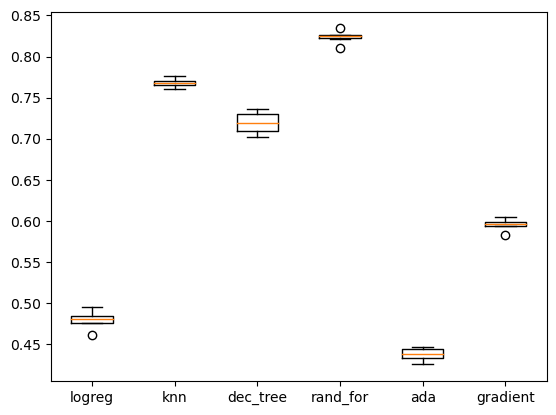

In [580]:
plt.boxplot(results, labels=models.keys())
plt.show()

**Observations:**
\
Our Random Forest looks to be the best option. Hopefully it's not ignoring all the minor classes. Let's explore this model futher.

### 3.9.1 Random Forest Classifier

This time I'll use RandomizedSearchCV to tune params. Source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

#### 3.9.1.0 Create Parameter Grid

In [581]:
#list out our different params
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] #number of trees in the forest
max_features = ['log2','sqrt'] #number of features to consider at each split
max_depth = [int(x) for x in np.linspace(10, 110, num=11)] #max levels in tree
min_samples_split = [2,5,10] #min samples required to split a node
min_samples_leaf = [1,2,4] #min samples at each leaf node
bootstrap = [True, False] #sampling method using bootsrap or not

#Create random grid
rand_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(rand_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['log2', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [582]:
X_res_transformed

,diameter_breast_height_CM,age_at_obs,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between,temp_avg_normal,prcp_mm_normal,(american) arborvitae,(california) incense cedar,...,Willow oak,Wineleaf (spaethii sycamore),Wintergold crabapple,Yellowwood,Yoshino cherry,Zumi crabapple,missing,introduced,naturally_occurring,no_info
0,-0.719805,-1.840363,-0.648003,-2.231305,-0.984790,-0.102130,-0.750281,0.734990,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.719805,-0.976624,-0.648003,-2.231305,-0.984790,-1.798127,-0.750281,0.734990,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,-0.156720,-0.164390,0.842330,1.065960,0.978043,0.009061,1.341023,-1.257013,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.124883,-1.914660,-0.598560,0.008828,0.638199,1.749781,-0.750281,0.734990,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.816213,-0.188662,-1.500084,1.580015,0.253067,0.683313,-0.750281,0.734990,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22045,1.392659,0.653267,-1.372165,0.432539,-0.984790,-0.682808,-0.750281,0.734990,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22046,1.546000,0.774459,-0.500394,0.305456,-0.984790,0.440064,-0.750281,0.734990,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22047,-1.124883,-1.347973,1.162368,-0.168622,1.091227,0.201770,1.341023,-1.257013,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22048,0.963013,0.854333,0.842330,1.065960,0.978043,-0.638237,1.341023,-1.257013,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### 3.9.1.1 Fit with Random Search

In [495]:
#Initiate the model
rf = RandomForestClassifier()

#Random Search Cross-Val
rf_rand = RandomizedSearchCV(estimator=rf, param_distributions=rand_grid, n_iter=10, cv=5, verbose=2, random_state=42) #sample 50 param settings, 5 fold cross-val, computation time display

#fit the model on the non-scaled data
rf_rand.fit(X_res_transformed, y_res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  36.2s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  36.2s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  36.3s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  36.2s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  36.3s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time=  26.9s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_es

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

#### 3.9.1.2 Review Results

In [583]:
params = rf_rand.best_params_

params

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 100,
 'bootstrap': True}

#### 3.9.1.3 Fit Model Using Best Parms

In [587]:
#Run a fit with those params and view more details scoring

#setup model
rf_tuned = RandomForestClassifier(n_estimators=1800, min_samples_split=5, min_samples_leaf=1, max_features='log2', max_depth=100, bootstrap=True)

#fit model
rf_tuned.fit(X_res_transformed, y_res)

#review scores
print(f'Accuracy on training data: {accuracy_score(rf_tuned.predict(X_res_transformed), y_res):.2f}')
print("Classification Report for Training Data")
print(classification_report(y_res, rf_tuned.predict(X_res_transformed)))

Accuracy on training data: 0.98
Classification Report for Training Data
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      4410
         2.0       0.99      0.99      0.99      4410
         3.0       0.97      0.97      0.97      4410
         4.0       0.97      0.97      0.97      4410
         5.0       0.98      0.99      0.99      4410

    accuracy                           0.98     22050
   macro avg       0.98      0.98      0.98     22050
weighted avg       0.98      0.98      0.98     22050



**Observations:**
\
Siri, what's the definition of overfitting? K Thanks. I've got a bad feeling about the test set but let's see how it goes!

### 3.9.2 Evaluate RF Model on Test Set

The first thing we'll need to do is process our X_test using the same steps we did on our X_train.

#### 3.9.2.0 Pre-Processing X_test

In [152]:
#Update object to categorical
X_test['common_name'] = X_test.common_name.astype('category')
X_test['native'] = X_test.native.astype('category')

X_test.dtypes

common_name                  category
diameter_breast_height_CM     float64
native                       category
age_at_obs                    float64
adj_reports                     int64
norm_prcp_mm_total            float64
norm_snow_mm_total            float64
distance_between              float64
temp_avg_normal               float64
temp_min_normal               float64
temp_max_normal               float64
temp_range_normal             float64
prcp_mm_normal                float64
dtype: object

In [187]:
#refit imputers
num_imputer.fit(X_res[['age_at_obs']])
cat_imputer.fit(X_res[['common_name']])

#refit ohe on x_res
ohe.fit(X_res[['common_name','native']])

#Apply transformations from the steps we fitted earlier in the model
X_test['age_at_obs'] = num_imputer.transform(X_test[['age_at_obs']])
X_test['common_name'] = cat_imputer.transform(X_test[['common_name']])

X_test_transformed = ohe.transform(X_test[['common_name','native']])

/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [189]:
X_test_transformed

<2000x308 sparse matrix of type '<class 'numpy.float64'>'
	with 1707 stored elements in Compressed Sparse Row format>

In [191]:
#refit on unscaled data
rf_tuned.fit(x_res_encoded, y_res)

#predict
y_pred = rf_tuned.predict(X_test_transformed)

print(f'Accuracy on training data: {accuracy_score(y_pred, y_test):.2f}')
print("Classification Report for Training Data")
print(classification_report(y_test, y_pred))
print('----------------------------------------')
print(confusion_matrix(y_test, y_pred))

Accuracy on training data: 0.48
Classification Report for Training Data
              precision    recall  f1-score   support

         1.0       0.03      0.05      0.04        39
         2.0       0.16      0.15      0.16        93
         3.0       0.37      0.29      0.33       503
         4.0       0.59      0.69      0.63      1091
         5.0       0.27      0.17      0.21       274

    accuracy                           0.48      2000
   macro avg       0.28      0.27      0.27      2000
weighted avg       0.46      0.48      0.46      2000

----------------------------------------
[[  2   7   3  25   2]
 [  2  14  29  46   2]
 [ 10  23 145 291  34]
 [ 41  32 176 753  89]
 [  9  11  36 171  47]]


**Observations:**
\
\
As we'd expect from a lower training result, our test results aren't all that much better than a random guess if my math is correct. I will go ahead and export the model, but will continue to research and round back to see if there are any useful features that could be added or engineered to achieve better results.

## 4.0 Save Model

### 4.0.0 Define Saving Functions

In [215]:
#define functions for saving model provided by Springboard Guided Capstone
def _save_file(data, fpath):
    valid_ftypes = ['.csv', '.pkl']
    
    assert (fpath[-4:] in valid_ftypes), "Invalid file type.  Use '.csv' or '.pkl'"

    # Figure out what kind of file we're dealing with by name
    if fpath[-3:] == 'csv':
        data.to_csv(fpath, index=False)
    elif fpath[-3:] == 'pkl':
        with open(fpath, 'wb') as f:
            pickle.dump(data, f)

def save_file(data, fname, dname):
    """Save a datafile (data) to a specific location (dname) and filename (fname)
    
    Currently valid formats are limited to CSV or PKL."""
    
    if not os.path.exists(dname):
        os.mkdir(dname)
        print(f'Directory {dname} was created.')
        
    fpath = os.path.join(dname, fname)
    
    
    if os.path.exists(fpath):
        print("A file already exists with this name.\n")

        yesno = None
        while yesno != "Y" and yesno != "N":
            yesno = input('Do you want to overwrite? (Y/N)').strip()[0].capitalize()
            if yesno == "Y":
                print(f'Writing file.  "{fpath}"')
                _save_file(data, fpath)
                break  # Not required
            elif yesno == "N":
                print('\nPlease re-run this cell with a new filename.')
                break  # Not required
            else:
                print('\nUnknown input, please enter "Y" or "N".')

    else:  # path does not exist, ok to save the file
        print(f'Writing file.  "{fpath}"')
        _save_file(data, fpath)

### 4.0.1 Identify Model Information

In [217]:
rf_model = rf_rand.best_estimator_
rf_model.version = '1.0'
rf_model.pandas_version = pd.__version__
rf_model.numpy_version = np.__version__
rf_model.sklearn_version = sklearn_version
rf_model.X_columns = [col for col in X_train.columns]
rf_model.build_datetime = dt.datetime.now()

In [218]:
#Save the model to the new /models folder
modelpath = '../models/'
save_file(rf_model, 'trees_rf_model.pkl', modelpath)

Writing file.  "../models/trees_rf_model.pkl"
